In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.style.use("seaborn-v0_8-darkgrid")  # Use the correct style name for matplotlib >= 3.6
sns.set_palette("muted")

# Load data
data_path = "../data"
tickers = ['AAPL', 'MSFT', 'JNJ', 'PFE']

data = {}
for ticker in tickers:
    file_path = os.path.join(data_path, f"{ticker}.csv")
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df = df[['Close']].rename(columns={'Close': ticker})
    data[ticker] = df

# Merge all tickers into one DataFrame
df_all = pd.concat(data.values(), axis=1)
df_all.dropna(inplace=True)
df_all.head()

,AAPL,MSFT,JNJ,PFE
Date,,,,
NaT,AAPL,MSFT,JNJ,PFE
2015-01-02,24.288578033447266,39.99871063232422,78.01262664794922,19.346155166625977
2015-01-05,23.60433006286621,39.630882263183594,77.46775817871094,19.24118423461914
2015-01-06,23.606552124023438,39.04921340942383,77.08709716796875,19.401735305786133
2015-01-07,23.937578201293945,39.545345306396484,78.78886413574219,19.667253494262695


In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Use the AAPL price series, skip the header if present and convert to float
if 'data' not in globals():
    raise NameError("The variable 'data' is not defined. Please run the cell that defines 'data' first.")
aapl_series = data['AAPL']['AAPL'].dropna().values[1:].astype(float).reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_series)

# Create sequences (e.g., 60 days of history to predict the next day)
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape input to 3D: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\GODIWOUR\AppData\Local\anaconda\envs\stock_forecast\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
history = model.fit(X, y, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0262
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0021
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0018
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0016
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0017
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0015
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0013
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0014
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0012


In [18]:
# Predict the next 30 days
forecast_days = 30
predictions = []

last_sequence = scaled_data[-sequence_length:]

for _ in range(forecast_days):
    seq_input = last_sequence.reshape(1, sequence_length, 1)
    predicted = model.predict(seq_input)[0][0]
    predictions.append(predicted)
    
    # Append the prediction to the sequence and update
    last_sequence = np.append(last_sequence[1:], [[predicted]], axis=0)

# Inverse transform to get real prices
forecasted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Save the predicted values to the 'results' folder
os.makedirs('results', exist_ok=True)
np.savetxt('results/aapl__lstm_forecasted_prices.csv', forecasted_prices, delimiter=',', header='Forecasted_Price', comments='')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

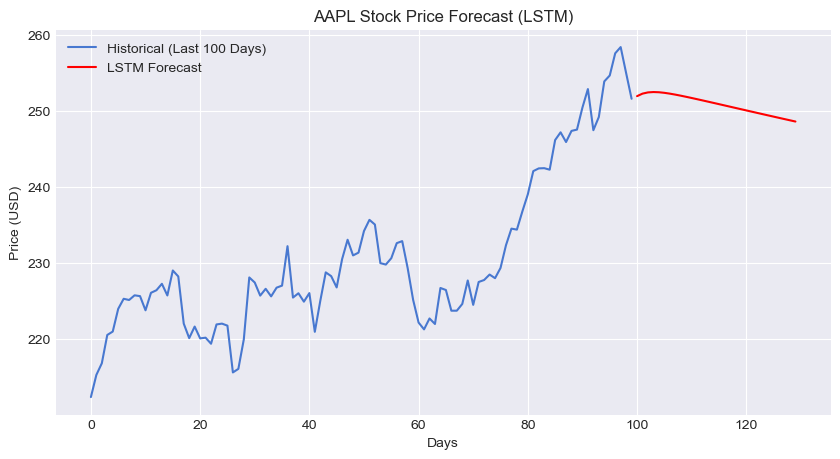

In [19]:
import matplotlib.pyplot as plt

# Plot historical and forecasted prices
plt.figure(figsize=(10, 5))
plt.plot(aapl_series[-100:], label="Historical (Last 100 Days)")
plt.plot(np.arange(100, 100+forecast_days), forecasted_prices, label="LSTM Forecast", color='red')
plt.title("AAPL Stock Price Forecast (LSTM)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
